# Polytop FDB Access: Bounding Box Feature

## Installation
See instruction in [Polytope installation](https://github.com/MeteoSwiss/nwp-fdb-polytope-demo/blob/main/README.md#Installation-1)

**Configuring Access to Polytope**

In [ ]:
import os

#ECMWF polytope credentials
# leave empty for ICON-CSCS polytope
os.environ["POLYTOPE_USER_KEY"] = ""
os.environ["POLYTOPE_USER_EMAIL"] = ""

#ICON-CSCS polytope credentials
# leave empty for ecmwf polytope
os.environ["POLYTOPE_USER_KEY"] = "xxxx"
os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"
os.environ["POLYTOPE_LOG_LEVEL"] = "INFO"

**Selecting date,time of the forecast**

In [ ]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 6
rounded_hour = (past_time.hour // 6) * 6
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time


**Define and rotate bounding box points**
> **IMPORTANT**: The function `transform_point`() expects first longitude and then latitude.

In [ ]:
import cartopy.crs as ccrs

# point 1: top left corner, point 2: bottem right corner
geo_points = [[5.8, 47.81], [10.5, 45.81]] # bounding box arround Switzerland

# South pole rotation of lon=10, latitude=-43
rotated_crs = ccrs.RotatedPole(
    pole_longitude=190, pole_latitude=43
)

# Convert a point from geographic to rotated coordinates
geo_crs = ccrs.PlateCarree()
rotated_points = [
    rotated_crs.transform_point(lon, lat, geo_crs)
    for lon, lat in geo_points
]

**Define the request**
> **IMPORTANT**: Don't forget to specify that the data points are tuples that first contain longitude and then latitude.

In [14]:
from meteodatalab import mars

request = mars.Request(
    param="T_2M",
    date=date,
    time=time,
    model=mars.Model.ICON_CH1_EPS,
    levtype=mars.LevType.SURFACE,
    number=1,
    step=0,
    feature={
        "type" : "boundingbox",
        "points" : rotated_points,
        "axes" : ["longitude", "latitude"] #first lingitude, then latitude
    }
)

**Retrieve the data**

In [ ]:
import earthkit.data as ekd
ds = ekd.from_source(
    "polytope",
    "mchgj",
    request.to_polytope(),
    stream=False
).to_xarray()

**Rotate back to geo lat/lon**

In [16]:
unrotated_points = [
    geo_crs.transform_point(lon, lat, rotated_crs)
    for lon, lat in zip(ds.longitude,ds.latitude)
]

geo_lons, geo_lats = zip(*unrotated_points)

ds_geo = ds.assign_coords(
    longitude=("points", list(geo_lons)),
    latitude=("points", list(geo_lats))
)

**Convert to degree celsius**

In [17]:
da_geo = ds_geo['t_2m']
da_geo.values = da_geo.values - 273.15
da_geo.attrs['units'] = "°C"
da_geo.attrs['long_name'] = "2 Meter Temperature"

**Plot the data**

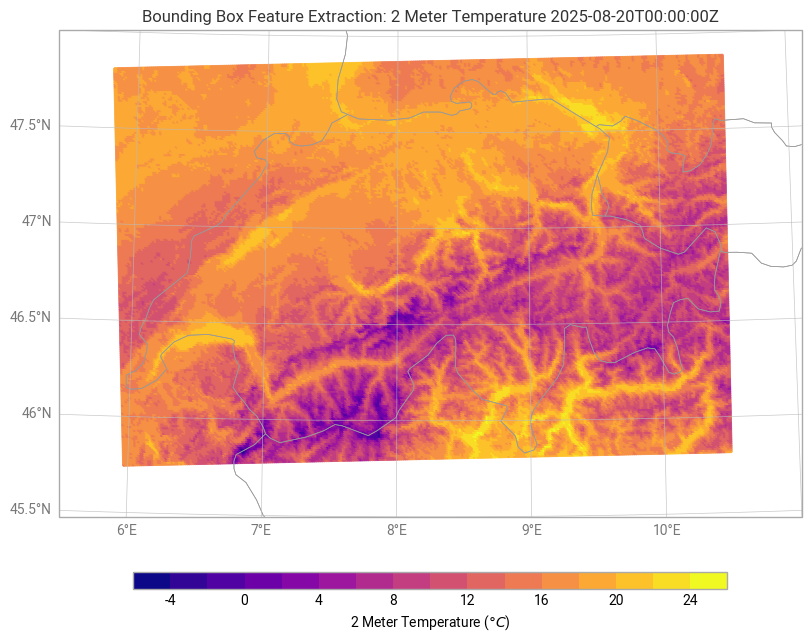

In [18]:
from earthkit.plots import Map
from earthkit.plots.geo import bounds, domains

xmin, xmax = 5.5, 11   # Longitude bounds
ymin, ymax = 45.5, 48   # Latitude bounds

bbox = bounds.BoundingBox(xmin, xmax, ymin, ymax, ccrs.Geodetic())
domain = domains.Domain.from_bbox(
    bbox=bbox,
    name="CH2"
)
chart = Map(domain=domain)
chart.point_cloud(da_geo, x="longitude", y="latitude")

chart.coastlines()
chart.borders()
chart.gridlines()


chart.title("Bounding Box Feature Extraction: {long_name} {datetimes}")

chart.legend()

chart.show()

In [12]:
da_geo

<xarray.DataArray 't_2m' (datetimes: 1, number: 1, steps: 1, points: 63342)> Size: 507kB
array([[[[15.0425354 , 15.26226196, 15.19976196, ..., 16.19390259,
          15.97417603, 15.53569946]]]])
Coordinates:
  * datetimes  (datetimes) <U20 80B '2025-08-20T00:00:00Z'
  * number     (number) int64 8B 1
  * steps      (steps) int64 8B 0
  * points     (points) int64 507kB 0 1 2 3 4 ... 63337 63338 63339 63340 63341
    latitude   (points) float64 507kB 45.75 45.75 45.75 ... 47.88 47.88 47.88
    longitude  (points) float64 507kB 6.115 6.13 6.144 ... 10.48 10.49 10.51
    levelist   (points) float64 507kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    type:       Parameter
    units:      °C
    long_name:  2 Meter Temperature